In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

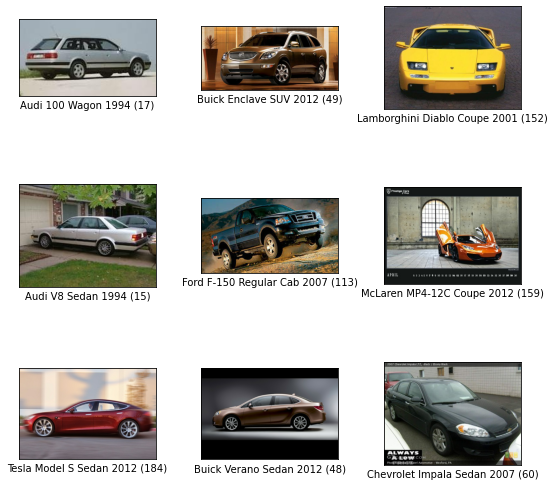

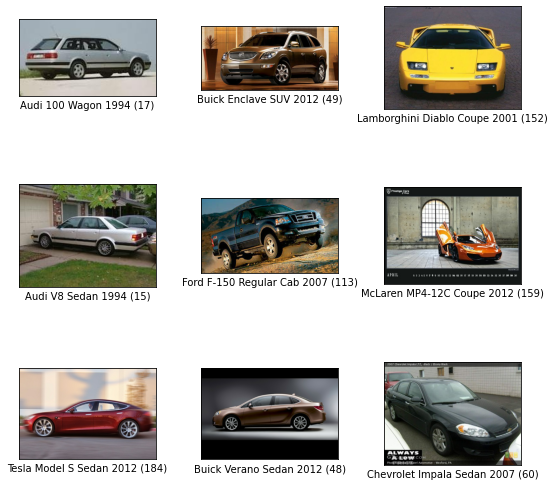

In [4]:
tfds.show_examples(ds_train, ds_info)

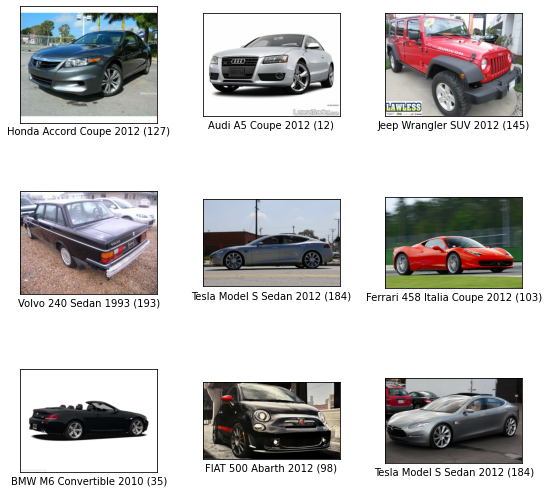

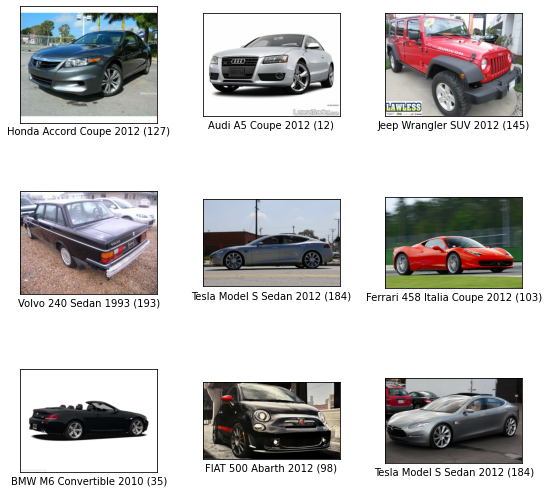

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

- tfds.features.BBoxFeature
  - bounding box [ymin, xmin, ymax, xmax]

In [7]:
ds_info.features["label"].names

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

# resnet50 base model

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

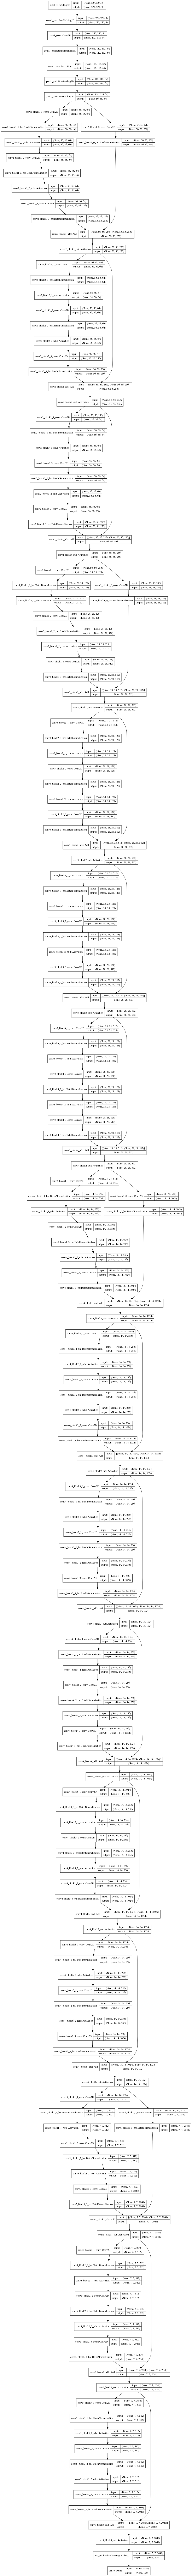

In [10]:
tf.keras.utils.plot_model(cam_model, show_shapes=True, dpi=64)

# CAM모델 학습~

- CAM은 weakly supervised learning이기에 dataset 전처리에서 bbox 제외~

In [11]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 119s 183ms/step - loss: 4.9430 - accuracy: 0.0626 - val_loss: 5.4489 - val_accuracy: 0.0086
Epoch 2/15
509/509 [==============================] - 81s 159ms/step - loss: 2.0270 - accuracy: 0.5461 - val_loss: 2.0366 - val_accuracy: 0.4964
Epoch 3/15
509/509 [==============================] - 81s 159ms/step - loss: 0.7384 - accuracy: 0.8636 - val_loss: 1.2730 - val_accuracy: 0.6688
Epoch 4/15
509/509 [==============================] - 81s 159ms/step - loss: 0.2339 - accuracy: 0.9737 - val_loss: 1.0922 - val_accuracy: 0.7102
Epoch 5/15
509/509 [==============================] - 81s 160ms/step - loss: 0.0898 - accuracy: 0.9957 - val_loss: 1.0374 - val_accuracy: 0.7217
Epoch 6/15
509/509 [==============================] - 82s 160ms/step - loss: 0.0470 - accuracy: 0.9979 - val_loss: 1.0017 - val_accuracy: 0.7313
Epoch 7/15
509/509 [==============================] - 82s 160ms/step - loss: 0.0259 - accuracy: 0.9988 - val_loss: 0.9809 - val_a

In [16]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


--------------------------------------------------------------------------------------------

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

120


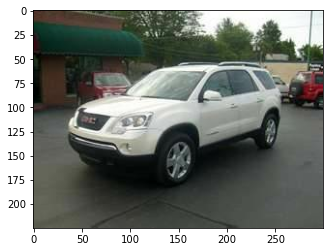

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [4]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) # 가변 output~
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))  # axis 0 dimension추가~
    
    # model.layers[-3].output -> conv_outputs : feature map
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    print('conv_outputs : ',conv_outputs.shape)
    print('class_weights : ', class_weights.shape)
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    print('cam_image : ', cam_image.shape)
    
    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다. linear_interpoltation
    return cam_image

conv_outputs :  (7, 7, 2048)
class_weights :  (2048, 196)
cam_image :  (7, 7)


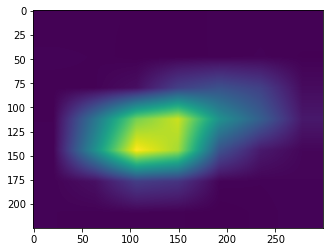

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

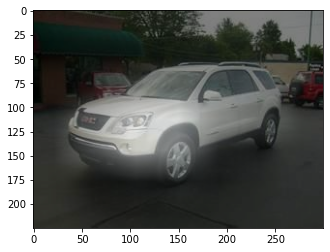

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Grad-CAM

130


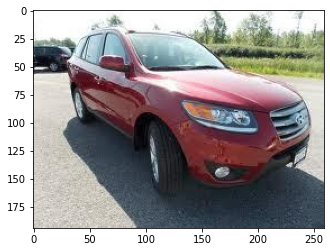

In [89]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

$$
L^c_{Grad_AM}(i,j) = ReLU(\sum_k a_k^c f_k(i,j)) \\
a_k^c = \frac{1}{Z}\sum_i\sum_j\frac{\partial S^c}{\partial f_k(i,j)}
$$

- $S^c$ : output의 class c값
- grad-cam은 weights대신 gradient값으로 대체
  - gradient는 $S^c$에 가해지는 영향력으로 생각해 볼 수 있다

In [90]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

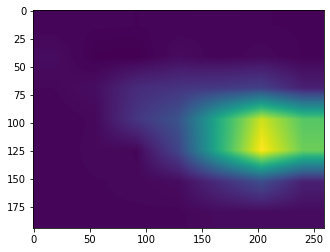

In [91]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

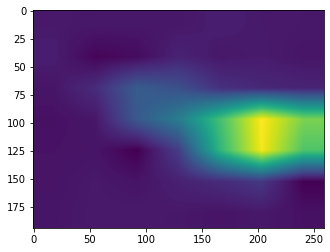

In [92]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)
plt.imshow(grad_cam_image)

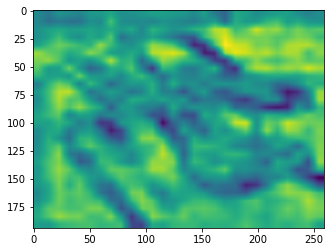

In [93]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

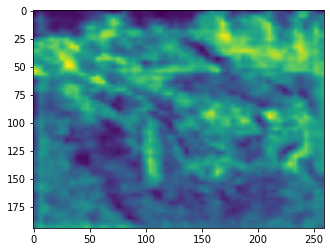

In [94]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)

# Detection with CAM & Grad-CAM

116


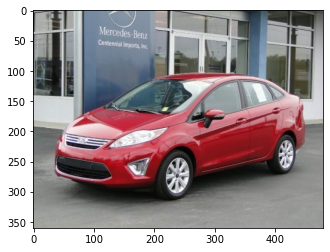

In [118]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

conv_outputs :  (7, 7, 2048)
class_weights :  (2048, 196)
cam_image :  (7, 7)


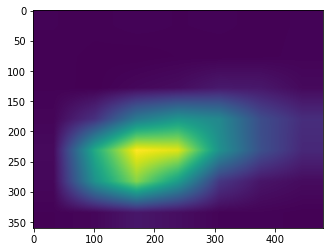

In [119]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [120]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [121]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 27, 146],
       [475, 105],
       [495, 330],
       [ 47, 370]])

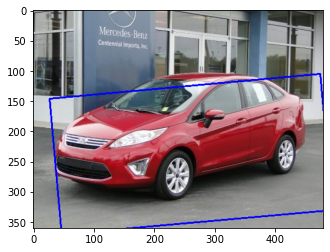

In [122]:
image_cam = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image_cam)

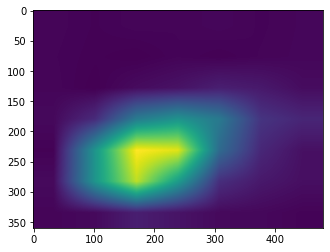

In [123]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [124]:
rect_grad = get_bbox(grad_cam_image)
rect_grad

array([[ 24, 149],
       [472,  99],
       [498, 325],
       [ 50, 376]])

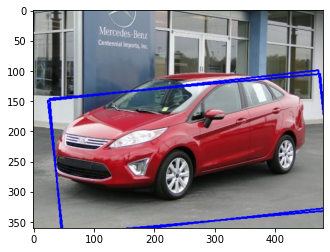

In [125]:
image_grad = cv2.drawContours(image,[rect_grad],0,(0,0,255),2)
plt.imshow(image_grad)

- 'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),

In [126]:
'''from PIL import Image, ImageDraw

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image'''

"from PIL import Image, ImageDraw\n\ndef visualize_bbox(input_image, object_bbox):\n    input_image = copy.deepcopy(input_image)\n    draw = ImageDraw.Draw(input_image)\n\n    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기\n    width, height = img.size\n    print('width:', width, ' height:', height)\n    print(object_bbox.shape)\n    x_min = object_bbox[:,1] * width\n    x_max = object_bbox[:,3] * width\n    y_min = height - object_bbox[:,0] * height\n    y_max = height - object_bbox[:,2] * height\n\n    # 바운딩 박스 그리기\n    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)\n    \n    for _rect in rects:\n        print(_rect)\n        draw.rectangle(_rect, outline=(255,0,0), width=2)\n    print(input_image)\n    return input_image"

In [127]:
print(type(image))

<class 'numpy.ndarray'>


In [128]:
print(type(item['bbox'].astype('float64').tolist()))
print(item['bbox'].tolist())

<class 'list'>
[0.2916666567325592, 0.07500000298023224, 0.875, 0.9437500238418579]


In [129]:
print(type(item['bbox']))

<class 'numpy.ndarray'>


In [130]:
#visualize_bbox(image, item['bbox'])

In [131]:
#origin_bbox = cv2.drawContours(image,item['bbox'].astype('float64').tolist(),0,(0,0,255),2)
#plt.imshow(origin_bbox)

In [132]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

## CAM bbox IoU

In [133]:
pred_bbox_cam = rect_to_minmax(rect, item['image'])
print(type(pred_bbox_cam[0]))
#pred_bbox_cam

<class 'numpy.float64'>


In [134]:
item['bbox']

array([0.29166666, 0.075     , 0.875     , 0.94375   ], dtype=float32)

In [135]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [136]:
print('CAM IoU')
get_iou(pred_bbox_cam, item['bbox'])

CAM IoU


0.7060957663148967

## Grad-CAM bbox IoU

In [137]:
pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])
pred_bbox_grad

[0.275, 0.05, 1.0444444444444445, 1.0375]

In [138]:
print('Grad-CAM IoU')
get_iou(pred_bbox_grad, item['bbox'])

Grad-CAM IoU


0.6669561839956788

- conv2_block3_out feature map Grad-CAM 

In [139]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv2_block3_out', item)
rect_grad2 = get_bbox(grad_cam_image2)
pred_bbox_grad2 = rect_to_minmax(rect_grad2, item['image'])
get_iou(pred_bbox_grad2, item['bbox'])

0.017677284108455784

- 몇개의 sample로 inference를 해보았지만 일단 CAM이든 Grad-CAM이든 detection task에 사용하는 것보다 visualization에 초점을 맞춰 의의를 두는게 맞다고 생각한다